In [2]:
# Change the width of the notebook cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100!important; }</style>"))

# A below code causes ipython's completer to bypass jedi and speeds up the
# loading time of the autocomplete menu to fix the unprompted autocomplete.
# %config Completer.use_jedi = False

# Applying Clustering Algorithms to Find Geographically Similar Headlines

**Objective**

Cluster (find groups of) headlines based on the geographic coordinates using both k-means clustering and DBSCAN. Visualize the clusters on a world map to check the results. Try different parameters and distance measures in the algorithms to produce better clusters.

**Workflow**

1. Apply k-means clustering and the DBSCAN algorithm to the latitude and longitude of each headline.
    * Use the default initial parameters for the algorithm or, if you have prior experience, choose parameters you think will work well.
    * Assign the cluster labels as another column on the DataFrame.
1. Visualize the clusters on a world map using the Basemap library. Color the headlines by the cluster assignment.
    * Determine if the clusters are reasonable: Are headlines geographically close to one another in the same cluster?
    * Write a visualization function to quickly check clustering results.
1. In the likely case that the first clustering is not ideal, adjust the parameters of the algorithm you choose or use a different algorithm.
    * You can use an [elbow plot](https://bl.ocks.org/rpgove/0060ff3b656618e9136b) to select the number of clusters in k-means.
    * The two most important parameters for DBSCAN are ***eps*** and ***min_samples***
1. Try using DBSCAN with the great circle distance, which finds the distance between two geographic points on a spherical globe.
    * Write a function to return the Great Circle distance between two coordinate points.
    * Use this function as the ***metric*** for DBSCAN.
1. Repeat the above steps—cluster, visualize, analyze, tune—as many times as is required until the algorithm correctly assigns close points to the same cluster without too many outliers.

**Importance to project**

* Clustering is a form of unsupervised learning that tries to match similar entities with features (for example, geographic coordinates) and a measure (for example, Euclidean distance between the coordinates). We don’t know ahead of time which headlines go in which clusters, so we need a machine learning algorithm to find the clusters for us based on the data we provide.

* We are using machine learning to extract additional information from our data set, but this time we are compressing the data instead of adding more. We use the algorithm’s output to focus on only the most important clusters and headlines instead of having to examine them all.

* **In the next section, we will interpret the algorithm’s output to identify disease outbreaks.**

> **Notes**
> 
> * You may be surprised that we are using our intuition—by visualizing the clusters—to determine if they are acceptable. This is common in data science: often the fastest way to find out if an algorithm is working properly is to assess the outputs with your own knowledge. We can be quite accurate in immediately spotting if something is off with the model.
> * Again, notice the iterative nature of this section. It will require several tries to find the best model parameters. Don’t get frustrated if you can’t figure them out at first. Also, don’t be afraid to go back and redo the previous sections if data quality is causing problems.

**Resources**

* Chapter 10, [Clustering with K-Means and DBSCAN](https://liveproject.manning.com/module/93_4_2/discovering-disease-outbreaks-from-news-headlines/3--clustering-headlines-based-on-location/3-2--clustering-with-kmeans-and-dbscan?), from *Data Science Bookcamp* by Leonard Apeltsin in section 3.2 can help you work with the clustering algorithms and tune the parameters.
* Chapter 11, [Plotting Maps with Basemap](https://liveproject.manning.com/module/93_4_3/discovering-disease-outbreaks-from-news-headlines/3--clustering-headlines-based-on-location/3-3--plotting-maps-using-basemap?), from *Data Science Bookcamp* by Leonard Apeltsin in section 3.3 can help you plot geographic maps of clustered headlines.
Referring to the Scikit-Learn documentation on these algorithms is crucial.
    * DBSCAN:
        - [Method documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
        - [User Guide](https://scikit-learn.org/stable/modules/clustering.html#dbscan)
    * K-Means:
        - [Method Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
        - [User Guide](https://scikit-learn.org/stable/modules/clustering.html#k-means)
    * [The Basemap documentation](https://basemaptutorial.readthedocs.io/en/latest/index.html#basemap-tutorial) is quite useful for picking up what you need to make a world map with the clustered headlines.

## Submit Your Work

The deliverable from this section is another Jupyter Notebook documenting your work as you cluster the headlines with the coordinates and produce a world map with clustered headlines. The map should show the locations of headlines colored by the cluster assignment. We will use this DataFrame and map to find disease outbreaks in the next section. A sample of the DataFrame showing the structure and content is below along with a partial map view:


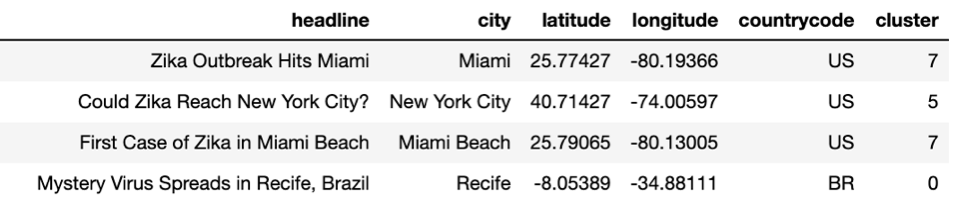
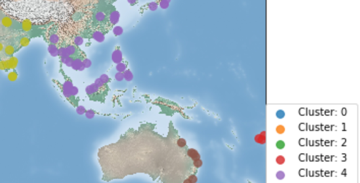

Upload a link to your Jupyter Notebook (preferably hosted on GitHub) in the blank below and hit submit. After submitting, you can view an example solution in the next section.

## Import al relevent library

In [6]:
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Regular expression
import re

import geonamescache

# Data analysis and wrangling
import numpy as np
import pandas as pd

from scipy.spatial.distance import euclidean

from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans

# Set plotting backend options for pandas
pd.options.plotting.backend = "plotly"

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 200)
# To set the float precision(the number of places after the decimal)
pd.set_option('precision', 4)

# Normalized unicode data (to remove accents)
from unidecode import unidecode
 
## Visualization
# matplotlib
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
# plotly express
import plotly.express as px
# Set default template
import plotly.io as pio
pio.templates.default = "simple_white"
# # Ignore warning
import warnings
warnings.filterwarnings('ignore')
# Visualizing the Earth using Basemap
# from mpl_toolkits.basemap import Basemap


from collections import Counter

## Functions

In [8]:
def color_null_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for NaN
    , black otherwise.
    """
    color = 'red' if str(val) == 'nan' else 'auto'

    return 'color: %s' % color


def style(df):
    return df.style.applymap(color_null_red)

## Import dataset

In [9]:
def gdrive_csv(link:str):
    id =link.split('/')[5]
    url = 'https://drive.google.com/uc?id='+id
    return pd.read_csv(url)

link = 'https://drive.google.com/file/d/1X28ZjiWPGVWykRgVdvqno4_y-P-4sSGo/view?usp=sharing'    
df = gdrive_csv(link)
df.head()

,headline,city,latitude,longitude,countrycode
0,Zika Outbreak Hits Miami,Miami,25.7743,-80.1937,US
1,Could Zika Reach New York City?,New York City,40.7143,-74.0060,US
2,First Case of Zika in Miami Beach,Miami Beach,25.7906,-80.1300,US
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.0539,-34.8811,BR
4,Dallas man comes down with case of Zika,Dallas,44.9193,-123.3170,US


In [10]:
df = pd.read_csv('2-finding_geolocations.csv')
df.head()

,headline,city,latitude,longitude,countrycode
0,Zika Outbreak Hits Miami,Miami,25.7743,-80.1937,US
1,Could Zika Reach New York City?,New York City,40.7143,-74.0060,US
2,First Case of Zika in Miami Beach,Miami Beach,25.7906,-80.1300,US
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.0539,-34.8811,BR
4,Dallas man comes down with case of Zika,Dallas,44.9193,-123.3170,US


In [11]:
df.info()
lst = [print('\n',col,':',f'had {len(set(df[col]))} unique values') for col in df.columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   headline     611 non-null    object 
 1   city         611 non-null    object 
 2   latitude     611 non-null    float64
 3   longitude    611 non-null    float64
 4   countrycode  611 non-null    object 
dtypes: float64(2), object(3)
memory usage: 24.0+ KB

 headline : had 609 unique values

 city : had 576 unique values

 latitude : had 576 unique values

 longitude : had 576 unique values

 countrycode : had 94 unique values


In [12]:
df.plot(x='longitude',y='latitude',kind='scatter')

In [13]:
def nearest_center(location):
    distances = [euclidean(location, center_e) for center_e in centers]
    return np.argmin(distances)


def color_cluster(locations):

    for i, location in enumerate(locations):
        index = nearest_center(location)
        df.loc[i, 'cluster'] = index

    df.cluster = df.cluster.astype('int').astype('category')
    #     print(f"The location at position {location} is closest to center {index}")
    return px.scatter(df, x='longitude',
                      y='latitude',
                      color='cluster',
                      symbol='cluster')


def color_by_cluster(locations):
    nearest_centers = [nearest_center(location) for location in locations]
    for cs_index in range(len(centers)):
        selected_locations = [locations[i] for i in range(len(locations))
                              if cs_index == nearest_centers[i]]

        y_coordinates, x_coordinates = np.array(selected_locations).T

        fig = px.scatter(x=x_coordinates,
                         y=y_coordinates,
                         color=[cs_index])
    fig.show();

In [14]:
def kmean_n_clusters(n):
    cluster_model = KMeans(n_clusters=n)
    assigned_cluster = cluster_model.fit_predict(locations)
    df['cluster'] = pd.Series(assigned_cluster)
    df.cluster = df.cluster.astype('int').astype('category')
    fig = px.scatter_mapbox(df,
                            lat='latitude',
                            lon='longitude',
                            color='cluster',
                            hover_name=df.city+', '+df.countrycode,
                            zoom=0.3,
                            center={'lat': 31.7, 'lon': 35.2},
                            size_max=0.1,
                            mapbox_style='open-street-map')
    # update
    fig.show()

In [27]:
# map_plotter = Basemap(projection='cyl')

# fig = plt.figure(figsize=(15, 12))

# map_plotter.scatter(x=df.longitude, 
#                     y=df.latitude, 
#                     c='red', 
#                     s=0.8, 
#                     latlon=True)

# map_plotter.shadedrelief()

# plt.show();

In [28]:
# coordinates = [[df.latitude.tolist()[i], df.longitude.tolist()[i]]
#              for i in range(len(df.latitude.tolist()))]

# centers = np.array(coordinates[:3])

# for i, coordinate in enumerate(coordinates):
#     index = nearest_center(coordinate)
#     df.loc[i, 'cluster'] = index
# df.cluster = df.cluster.astype('int').astype('category')
# # color_cluster(coordinates)

# fig = plt.figure(figsize=(15, 12))
# map_plotter.scatter(x=df.longitude, 
#                     y=df.latitude, 
#                     c=df.cluster, 
#                     s=3,                    
#                     latlon=True)

# map_plotter.shadedrelief()

# plt.show();

In [17]:
fig = px.scatter_mapbox(df,
                        lat='latitude',
                        lon='longitude',
                        color='cluster',
                        hover_name=df.city+', '+df.countrycode,
                        zoom=0.3,
                        center={'lat':31.7,'lon':35.2},
                        size_max=0.1,
                        mapbox_style='open-street-map')
# update
fig.show();

<Figure size 1080x864 with 0 Axes>

In [18]:
locations = [[df.latitude.tolist()[i],
              df.longitude.tolist()[i]] for i in range(len(df.latitude))]

k_values = range(1, 10)

inertia_values = [KMeans(k).fit(locations).inertia_ for k in k_values]

px.line(x=k_values, 
        y=inertia_values, 
        labels={'x': 'K', 
                'y': 'Inertia'},
        title='The inertia plot for a location simulation containing 2 cluster targets.<br>The plot resembles an arm bent at the elbow. The elbow points directly to a K of 2. ',
        
       )

In [19]:
kmean_n_clusters(7)

**Density-based Spatial Clustering of Applications with Noise.**

Using **DBSCAN** with the great circle distance, which finds the distance between two geographic points on a spherical globe.
* Write a function to return the Great Circle distance between two coordinate points.
* Use this function as the metric for DBSCAN.

**The technique is executed thusly:**

1. We select a random point coordinate from a data list.
1. We obtain all neighbors within an epsilon distance of that point.
1. If less than min_points neighbors are discovered, we repeat step a using a different random point. Otherwise, we group our point and its neighbors into a single cluster.
1. We iteratively repeat steps b and c across all newly discovered neighbors. All neighboring dense points will get merged into the cluster. Our will iterations terminate after the cluster stops expanding.
1. Once we have extracted the entire cluster, we repeat steps a through e on all data-points whose density hasn’t yet been analyzed.

Find a suitable value for epsilon by calculating the distance to the nearest n points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced (think of the angle between your arm and forearm) and select that as epsilon.

(array([[0.        , 0.        ],
        [0.        , 0.07666056],
        [0.        , 0.06568513],
        ...,
        [0.        , 1.07975779],
        [0.        , 0.12466103],
        [0.        , 1.10967377]]),
 array([[501,   0],
        [  1, 568],
        [  2,   0],
        ...,
        [608, 263],
        [609, 408],
        [610, 500]], dtype=int64))

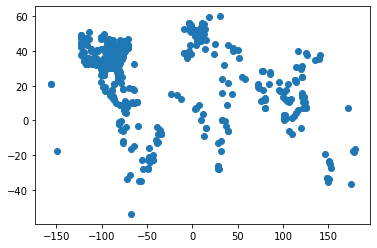

In [20]:
from sklearn.neighbors import NearestNeighbors 
plt.scatter(df.longitude,df.latitude);
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(locations)
distances, indices = nbrs.kneighbors(locations)

distances, indices

In [21]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
px.line(y=distances )

In [22]:
def dbscan_eps(epsilon, min_points) :
    
    color = ['black','green', 'yellow', 'gray', 'red', 'blue', 'orange', 'violet']
    longitudes, latitudes  = np.array(locations).T

    cluster_model = DBSCAN(eps=epsilon, min_samples=min_points)
    clusters = cluster_model.fit_predict(locations)
    Counter(clusters).most_common(10)
    colors = []
    for cluster in clusters:
        if cluster < 0:
            co_m = 'black'
            colors.append(co_m)
        else:
            co_n = color[:max(clusters)+1][cluster] 
            colors.append(co_n)
    clusters= [str(v) for v in clusters]   
    fig = px.scatter_mapbox(df,
                        lat='latitude',
                        lon='longitude',
                        color='cluster',
                        hover_name=df.city+', '+df.countrycode,
                        zoom=0.3,
                        center={'lat':31.7,'lon':35.2},
                        size_max=0.1,
                        color_discrete_map={'-1':'black'},
                        mapbox_style='open-street-map')
    fig.show();
#     fig = px.scatter(x=latitudes , 
#                y=longitudes , 
#                color=clusters, 
#                color_discrete_map={'-1':'black'},
#                labels={'color':'Cluster'})

#     return Counter(clusters)

In [23]:
locations = [[df.latitude.tolist()[i],
              df.longitude.tolist()[i]] for i in range(len(df.latitude))]
dbscan_eps(6.2, 9)

In [24]:
df_cluster = df[['latitude', 'longitude', 'cluster']]
cluster_lst = []
for n in range(len(df.cluster.unique())):
    df_lst = df_cluster[df_cluster.cluster == n]
    locations = list(zip(df_cluster.latitude, df_cluster.longitude))
    cluster_lst.append(locations)
# cluster_lst[0]    

In [29]:
# map = Basemap()
# fig = plt.figure(figsize=(12, 8))    
# latitudes , longitudes = np.array(locations).T
# cluster=df.cluster.values
# map.scatter(longitudes, latitudes, latlon=True, c=cluster,alpha=0.5)
# map.shadedrelief()
# plt.show();

In [30]:
# map = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, lat_1=33, lat_2=45)

# fig = plt.figure(figsize=(12, 8))
# latitudes , longitudes = np.array(locations).T
# map.scatter(longitudes, latitudes, latlon=True)
# map.shadedrelief()
# plt.show();